In [1]:
# Importowanie potrzebnych bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from datetime import datetime, timedelta
import sys
sys.path.append('..')  
from src.data_loader import load_transport_data
# Ustawienia wizualizacji
plt.style.use('ggplot')
sns.set_palette("Set2")
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

from src.data_structures import TransportConnection, TransportStop, TransportRoute
from src.utils import time_to_minutes, minutes_to_time, calculate_distance, estimate_travel_time
from src.data_loader import load_transport_data
from src.algorithms.dijkstra import dijkstra_shortest_path
from src.algorithms.astar import astar_shortest_path
from src.algorithms.astar_transfers import astar_min_transfers
from src.visualization import format_route, visualize_route, format_compact_route
from src.algorithms.astar import zero_heuristic
from src.algorithms.astar import distance_heuristic
from src.algorithms.astar import direct_line_preference_heuristic
from src.algorithms.astar import combined_heuristic
from src.algorithms.astar_advanced import astar_bi_criteria, get_cached_time_heuristic, get_cached_transfers_heuristic

In [2]:
# Funkcja do wczytywania danych z pliku CSV
def load_data_from_csv(csv_file):
    """
    Wczytuje dane z pliku CSV i tworzy struktury danych dla algorytmów routingu.
    """
    # Wczytanie pliku CSV
    df = pd.read_csv(csv_file)
    
    print(f"Wczytano {len(df)} połączeń komunikacyjnych z pliku {csv_file}")
    
    # Wywołanie funkcji ładującej dane transportowe

    stops, connections = load_transport_data(csv_file)
    
    print(f"Utworzono {len(stops)} przystanków i {len(connections)} połączeń")
    
    return stops, connections

In [3]:
# Funkcja do generowania losowych przypadków testowych
def generate_random_test_cases(stops, num_tests=30):
    """
    Generuje losowe przypadki testowe na podstawie dostępnych przystanków.
    """
    test_cases = []
    
    # Pobierz nazwy przystanków
    bus_stops_names = list(stops.keys())
    
    # Upewnij się, że mamy co najmniej 2 przystanki
    if len(bus_stops_names) < 2:
        raise ValueError("Potrzeba co najmniej 2 przystanków do wygenerowania przypadków testowych")
    
    # Generuj losowe przypadki testowe
    for _ in range(num_tests):
        start_stop, end_stop = random.sample(bus_stops_names, 2)
        departure_time = f"{random.randint(6, 21):02d}:{random.randint(0, 59):02d}:00"

        test_cases.append({
            "start_stop": start_stop,
            "end_stop": end_stop,
            "departure_time": departure_time
        })
    
    return test_cases

In [4]:
# Funkcja do uruchamiania testów
def run_algorithm_tests(test_cases, stops, connections):
    """
    Uruchamia testy dla różnych algorytmów i zapisuje wyniki.
    """
    # Importowanie algorytmów
    
    
    results = []
    
    for i, test_case in enumerate(test_cases):
        start_stop = test_case["start_stop"]
        end_stop = test_case["end_stop"]
        departure_time = test_case["departure_time"]
        
        print(f"Test {i+1}/{len(test_cases)}: {start_stop} -> {end_stop}, departure: {departure_time}")
        
        try:
            # Dijkstra
            print("Uruchamiam Dijkstra...")
            start_time = time.time()
            route_dijkstra = dijkstra_shortest_path(stops, start_stop, end_stop, departure_time)
            dijkstra_time = time.time() - start_time
            dijkstra_visited = getattr(route_dijkstra, 'visited_nodes', 0)
            
            # A*
            print("Uruchamiam A*...")
            start_time = time.time()
            route_astar = astar_shortest_path(stops, start_stop, end_stop, departure_time)
            astar_time = time.time() - start_time
            astar_visited = getattr(route_astar, 'visited_nodes', 0)
            
            # A* Min Transfers
            print("Uruchamiam A* Min Transfers...")
            start_time = time.time()
            route_min_transfers = astar_min_transfers(stops, start_stop, end_stop, departure_time)
            min_transfers_time = time.time() - start_time
            min_transfers_visited = getattr(route_min_transfers, 'visited_nodes', 0)
            
            # A* Advanced
            print("Uruchamiam A* Advanced...")
            start_time = time.time()
            route_advanced = astar_bi_criteria(stops, start_stop, end_stop, departure_time)
            advanced_time = time.time() - start_time
            advanced_visited = getattr(route_advanced, 'visited_nodes', 0)
            
            # Pobieranie danych z tras
            dijkstra_route_time = getattr(route_dijkstra, 'total_time', None)
            astar_route_time = getattr(route_astar, 'total_time', None)
            min_transfers_route_time = getattr(route_min_transfers, 'total_time', None)
            advanced_route_time = getattr(route_advanced, 'total_time', None)
            
            dijkstra_transfers = getattr(route_dijkstra, 'transfers', None)
            astar_transfers = getattr(route_astar, 'transfers', None)
            min_transfers_transfers = getattr(route_min_transfers, 'transfers', None)
            advanced_transfers = getattr(route_advanced, 'transfers', None)
            
            # Zapisujemy wyniki
            results.append({
                "test_id": i,
                "start_stop": start_stop,
                "end_stop": end_stop,
                "departure_time": departure_time,
                "dijkstra_time": dijkstra_time,
                "astar_time": astar_time,
                "min_transfers_time": min_transfers_time,
                "advanced_time": advanced_time,
                "dijkstra_route_time": dijkstra_route_time,
                "astar_route_time": astar_route_time,
                "min_transfers_route_time": min_transfers_route_time,
                "advanced_route_time": advanced_route_time,
                "dijkstra_transfers": dijkstra_transfers,
                "astar_transfers": astar_transfers,
                "min_transfers_transfers": min_transfers_transfers,
                "advanced_transfers": advanced_transfers,
                "dijkstra_nodes": dijkstra_visited,
                "astar_nodes": astar_visited,
                "min_transfers_nodes": min_transfers_visited,
                "advanced_nodes": advanced_visited
            })
            
            print(f"Test {i+1} zakończony pomyślnie")
            
        except Exception as e:
            print(f"Błąd w teście {i+1}: {str(e)}")
    
    return pd.DataFrame(results)

In [5]:
# Funkcja do generowania wykresów
def plot_algorithm_comparisons(results_df):
    """
    Generuje cztery wykresy porównujące różne aspekty algorytmów.
    """
    # Zapisujemy wyniki do CSV dla ewentualnej późniejszej analizy
    results_df.to_csv('algorithm_comparison_results.csv', index=False)
    
    # Wykres 1: Porównanie czasów wykonania algorytmów
    plt.figure(figsize=(12, 8))
    
    times_df = results_df[['dijkstra_time', 'astar_time', 'min_transfers_time', 'advanced_time']]
    times_df.columns = ['Dijkstra', 'A*', 'A* Min Transfers', 'A* Advanced']
    
    sns.boxplot(data=times_df)
    plt.title('Porównanie czasów wykonania algorytmów', fontsize=16)
    plt.ylabel('Czas wykonania (s)', fontsize=14)
    plt.xlabel('Algorytm', fontsize=14)
    plt.xticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('execution_times_comparison.png', dpi=300)
    plt.show()
    
    # Wykres 2: Porównanie liczby odwiedzonych węzłów
    plt.figure(figsize=(12, 8))
    
    nodes_df = results_df[['dijkstra_nodes', 'astar_nodes', 'min_transfers_nodes', 'advanced_nodes']]
    nodes_df.columns = ['Dijkstra', 'A*', 'A* Min Transfers', 'A* Advanced']
    
    sns.boxplot(data=nodes_df)
    plt.title('Porównanie liczby odwiedzonych węzłów', fontsize=16)
    plt.ylabel('Liczba odwiedzonych węzłów', fontsize=14)
    plt.xlabel('Algorytm', fontsize=14)
    plt.xticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('visited_nodes_comparison.png', dpi=300)
    plt.show()
    
    # Wykres 3: Porównanie liczby przesiadek
    plt.figure(figsize=(12, 8))
    
    transfers_df = results_df[['dijkstra_transfers', 'astar_transfers', 'min_transfers_transfers', 'advanced_transfers']]
    transfers_df.columns = ['Dijkstra', 'A*', 'A* Min Transfers', 'A* Advanced']
    
    sns.boxplot(data=transfers_df)
    plt.title('Porównanie liczby przesiadek w znalezionych trasach', fontsize=16)
    plt.ylabel('Liczba przesiadek', fontsize=14)
    plt.xlabel('Algorytm', fontsize=14)
    plt.xticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('transfers_comparison.png', dpi=300)
    plt.show()
    
    # Wykres 4: Porównanie czasu podróży
    plt.figure(figsize=(12, 8))
    
    route_times_df = results_df[['dijkstra_route_time', 'astar_route_time', 'min_transfers_route_time', 'advanced_route_time']]
    route_times_df.columns = ['Dijkstra', 'A*', 'A* Min Transfers', 'A* Advanced']
    
    # Przekształcenie ujemnych czasów podróży (trasy przez północ)
    for col in route_times_df.columns:
        route_times_df[col] = route_times_df[col].apply(lambda x: x + 1440 if x and x < 0 else x)
    
    sns.boxplot(data=route_times_df)
    plt.title('Porównanie czasu podróży w znalezionych trasach', fontsize=16)
    plt.ylabel('Czas podróży (min)', fontsize=14)
    plt.xlabel('Algorytm', fontsize=14)
    plt.xticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('route_times_comparison.png', dpi=300)
    plt.show()
    
    # Dodatkowy wykres - zależność między czasem podróży a liczbą przesiadek
    plt.figure(figsize=(14, 10))
    
    # Przygotowanie danych
    comparison_data = []
    
    for algo in ['dijkstra', 'astar', 'min_transfers', 'advanced']:
        for _, row in results_df.iterrows():
            route_time = row[f'{algo}_route_time']
            transfers = row[f'{algo}_transfers']
            
            # Korekta dla ujemnych czasów (trasy przez północ)
            if route_time and route_time < 0:
                route_time += 1440
            
            if route_time is not None and transfers is not None:
                comparison_data.append({
                    'Algorithm': algo.replace('_', ' ').title(),
                    'Route Time (min)': route_time,
                    'Transfers': transfers
                })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Wykres
    sns.scatterplot(data=comparison_df, x='Route Time (min)', y='Transfers', 
                    hue='Algorithm', s=100, alpha=0.7)
    
    plt.title('Zależność między czasem podróży a liczbą przesiadek', fontsize=16)
    plt.xlabel('Czas podróży (min)', fontsize=14)
    plt.ylabel('Liczba przesiadek', fontsize=14)
    plt.legend(title='Algorytm', fontsize=12, title_fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('time_vs_transfers.png', dpi=300)
    plt.show()

In [6]:
# Wczytanie danych z pliku CSV
csv_file_path = "../dane/connection_graph.csv"  # Dostosuj ścieżkę do swojego pliku
stops, connections = load_data_from_csv(csv_file_path)

/var/folders/3d/kz96fsfs35g30qwrnbhg5j8m0000gn/T/ipykernel_9776/3331589929.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


Wczytano 996520 połączeń komunikacyjnych z pliku ../dane/connection_graph.csv


/Users/m_juchiewicz/Desktop/studia/semestr-6/AI/lab01/rozwiazanie/notebooks/../src/data_loader.py:99: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


Wczytano 996520 połączeń komunikacyjnych
Utworzono 939 przystanków
Utworzono 939 przystanków i 1302344 połączeń


In [7]:
# Generowanie przypadków testowych
num_tests = 30  # Możesz dostosować liczbę testów
test_cases = generate_random_test_cases(stops, num_tests=num_tests)

In [8]:
# Uruchomienie testów - to może zająć trochę czasu
results = run_algorithm_tests(test_cases, stops, connections)

Test 1/30: ZWYCIĘSKA -> Domaszczyn - Trzebnicka, departure: 14:36:00
Uruchamiam Dijkstra...
Szukam trasy z 'ZWYCIĘSKA' do 'Domaszczyn - Trzebnicka' algorytmem Dijkstry
Szukam trasy z 'ZWYCIĘSKA' do 'Domaszczyn - Trzebnicka' od godziny 14:36:00
Odwiedzono 854 węzłów grafu
Znaleziono trasę, całkowity czas: 105.0 min, przesiadki: 3
Uruchamiam A*...
Szukam trasy z 'ZWYCIĘSKA' do 'Domaszczyn - Trzebnicka' algorytmem A*
Szukam trasy z 'ZWYCIĘSKA' do 'Domaszczyn - Trzebnicka' od godziny 14:36:00
Odwiedzono 928 węzłów grafu
Znaleziono trasę algorytmem A*, całkowity czas: 105.0 min, przesiadki: 5
Uruchamiam A* Min Transfers...
Szukam trasy z 'ZWYCIĘSKA' do 'Domaszczyn - Trzebnicka' od godziny 14:36:00 z minimalną liczbą przesiadek
Znaleziono trasę do 'Domaszczyn - Trzebnicka' z 2 przesiadkami!
Odwiedzono 4689 węzłów
Wykryto ujemny czas podróży, prawdopodobnie trasa przechodzi przez północ (00:00)
Faktyczny czas podróży: 1014.0 min
Uruchamiam A* Advanced...
Szukam trasy z 'ZWYCIĘSKA' do 'Domaszc

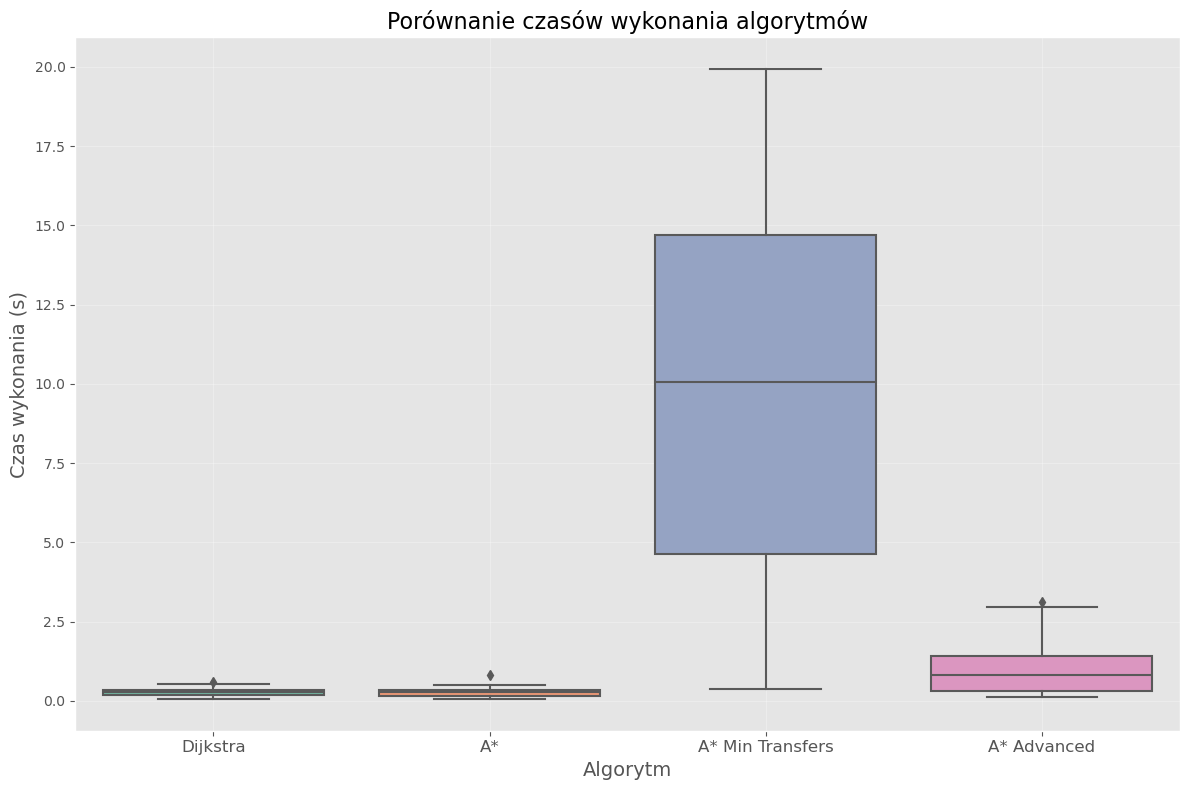

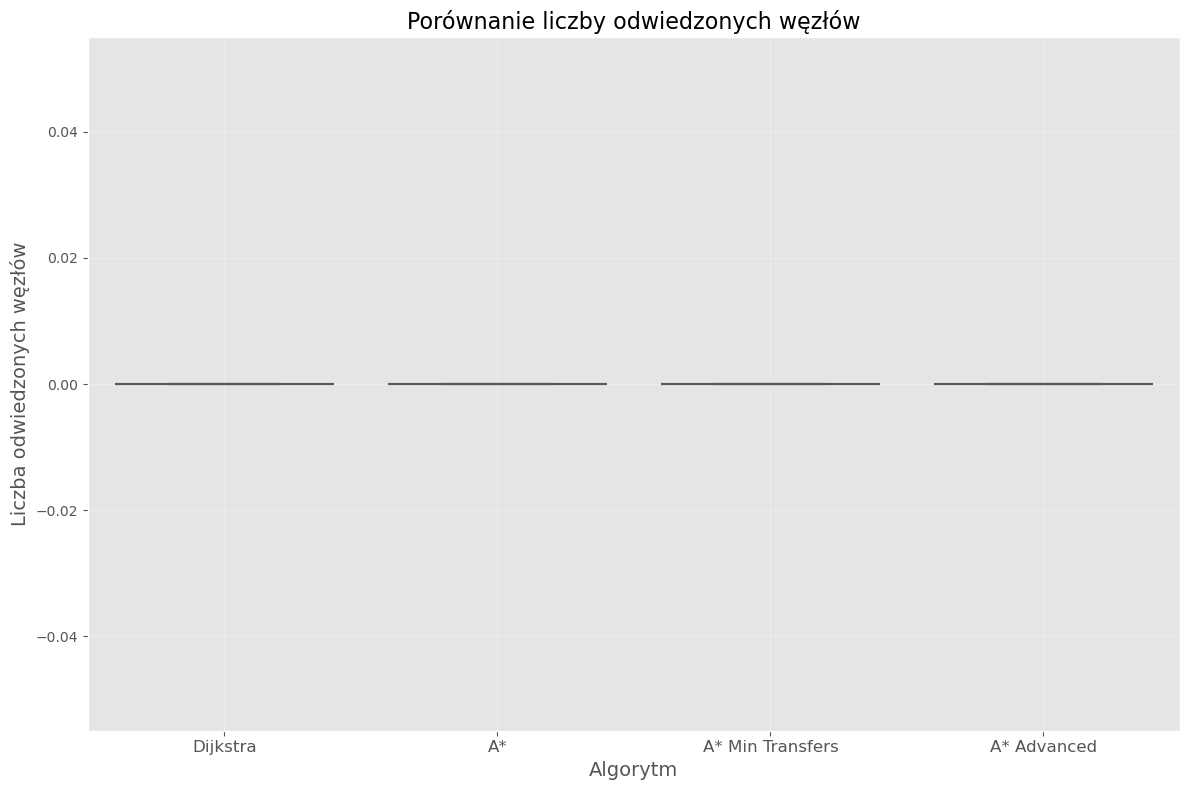

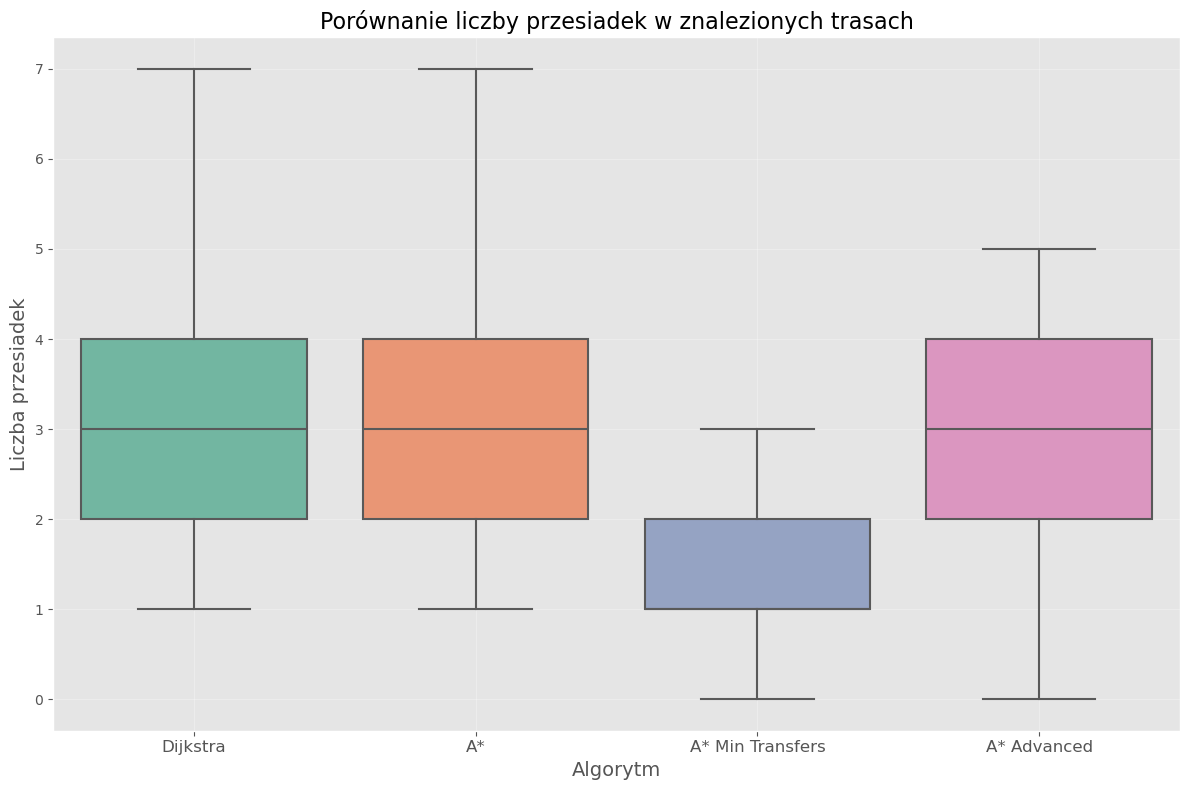

/var/folders/3d/kz96fsfs35g30qwrnbhg5j8m0000gn/T/ipykernel_9776/2170207638.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_times_df[col] = route_times_df[col].apply(lambda x: x + 1440 if x and x < 0 else x)


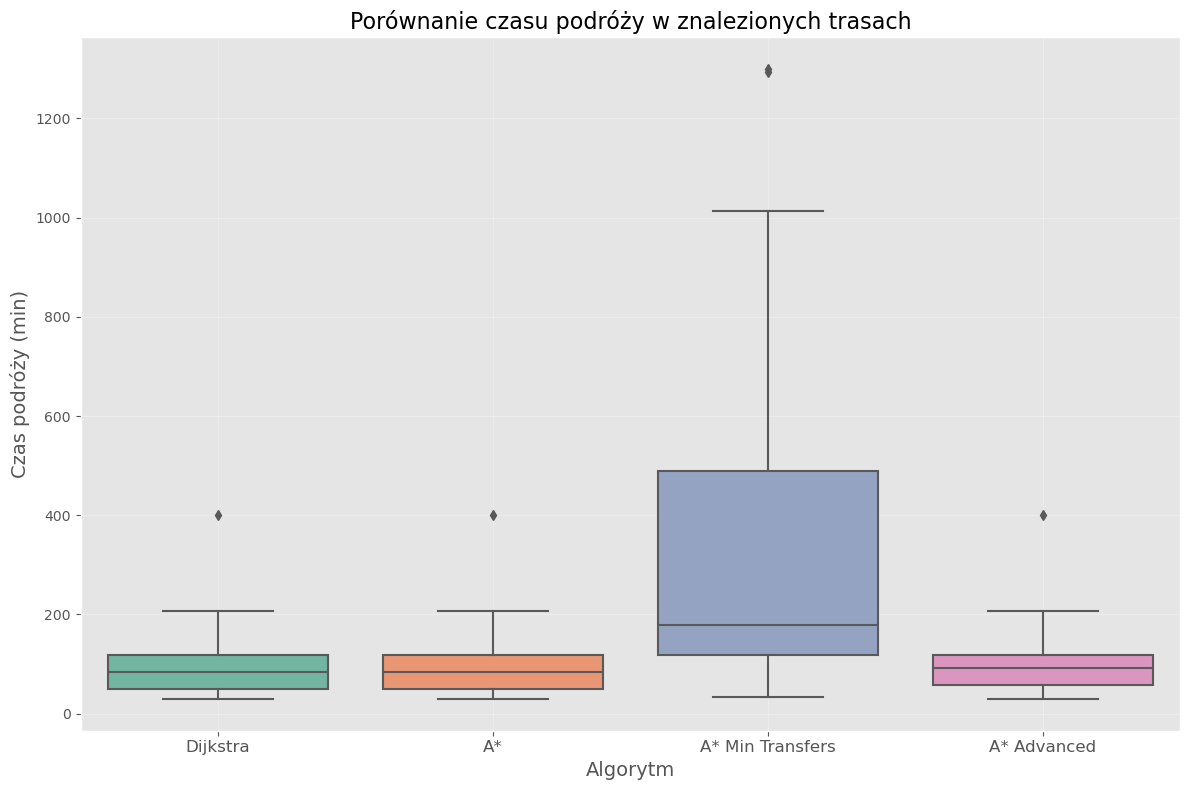

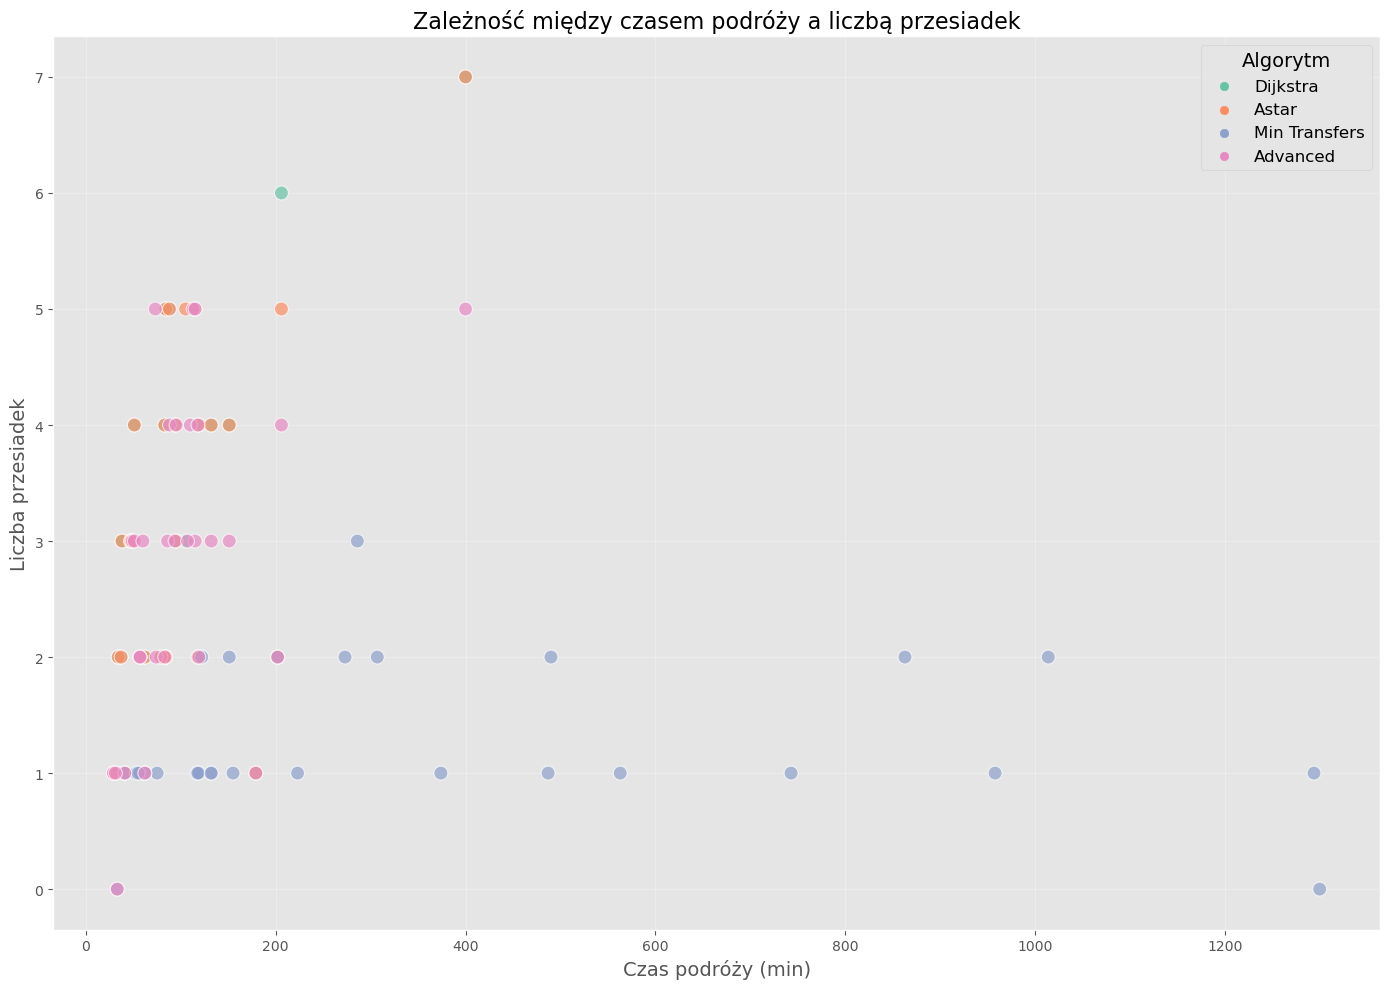

In [9]:
# Generowanie wykresów
plot_algorithm_comparisons(results)